**Define neural network model**

The neural network contains 5 layers, with linear and tanh activation functions

In [22]:
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
  def __init__(self, input_size=1, output_size = 1):
    super(NeuralNetwork, self).__init__()
    self.layer1_linear = nn.Linear(in_features=1, out_features=50)
    self.layer2_Tanh = nn.Tanh()
    self.layer3_linear = nn.Linear(in_features=50, out_features=20)
    self.layer4_Tanh = nn.Tanh()
    self.layer5_linear = nn.Linear(in_features=20, out_features=1)

  def forward(self, x):
    x = self.layer1_linear(x)
    x = self.layer2_Tanh(x)
    x = self.layer3_linear(x)
    x = self.layer4_Tanh(x)
    x = self.layer5_linear(x)
    return x

**Define loss functions**

In [23]:
def loss_DE(y_pred, X):
  dy_dt = torch.autograd.grad(y_pred,
                                X,
                                grad_outputs=torch.ones_like(y_pred),
                                create_graph=True)[0]
  d2y_dt2 = torch.autograd.grad(dy_dt,
                                X,
                                grad_outputs=torch.ones_like(y_pred),
                                create_graph=True)[0]
  loss_de = nn.MSELoss()(dy_dt + d2y_dt2 + y_pred, torch.zeros_like(y_pred))
  return loss_de

def loss_IC(y_true, y_pred):
  return nn.MSELoss()(y_true, y_pred)

In [24]:
# Define input
X = torch.arange(0.0, 5.0, 0.001).reshape(5000,1)
X.requires_grad_(True)

# Instantiate model
model = NeuralNetwork()

# Specify hyperparametrs
training_epochs = 5000
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [25]:
# Train model

for epoch in range(training_epochs):
  # Forward pass
  Y_pred = model(X)

  # Calculate predictions of y and dy_dx at x = 0
  x_0 = torch.tensor([[0.0]], requires_grad=True)
  y_0 = model(x_0)
  dy_dx_0 = torch.autograd.grad(y_0,x_0,grad_outputs=torch.ones_like(y_0),
                                create_graph=True)[0]

  # Calculate loss
  loss_de = loss_DE(Y_pred, X)
  loss_ic_y = loss_IC(y_0, torch.tensor([[1.0]]))
  loss_ic_dy = loss_IC(dy_dx_0, torch.tensor([[0.366]]))
  loss = loss_de + 10*(loss_ic_y)  + 5*(loss_ic_dy)

  # Set gradients to zero
  optimizer.zero_grad()

  # Compute gradients
  loss.backward()

  # Update parameters
  optimizer.step()

**Evaluate model**

Enter evaluation mode.  
Define test values of x from 0 to 2 with step size 0.01.  
Find predicted values of y from model


In [26]:
model.eval()
X_test = torch.arange(0.0, 5.0, 0.01).reshape(500,1) #
Y_pred = None
with torch.no_grad():
    Y_pred = model(X_test)
    print(f'First five predictions:\n{Y_pred[:5]}')

First five predictions:
tensor([[0.9981],
        [1.0017],
        [1.0051],
        [1.0084],
        [1.0116]])


Calculate function values of analytical solution   
y = e^(-x/2)[sin(3^0.5/2 * x)] + e^(-x/2)[sin(3^0.5/2 * x)] in interval [0,2]

In [27]:
from math import cos
from math import exp
from math import sin

Y_test = [0 for i in range(len(X_test))]
for i, x in enumerate(X_test):
  a = exp(-x/2)
  b =  sin(0.866*x) + cos(0.866*x)
  Y_test[i] = a * b
print(Y_test[:5]) # print first five values

[1.0, 1.0035918689456067, 1.0070481443695478, 1.0103698315627376, 1.0135579392043308]


Plot the analytic solution and model predictions

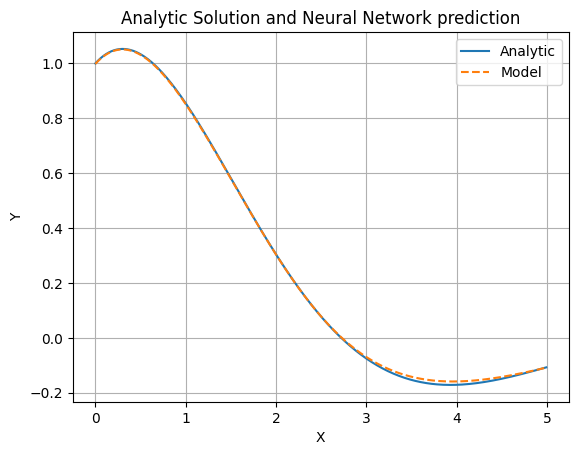

In [28]:
import matplotlib.pyplot as plt
import numpy as np

Y_pred = Y_pred.detach().cpu().numpy()
Y_test = np.array(Y_test)

plt.plot(X_test, Y_test, label='Analytic')
plt.plot(X_test, Y_pred, label='Model', linestyle='dashed')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Analytic Solution and Neural Network prediction')
plt.grid(True)
plt.show()